<h1>Import libraries

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import tensorflow as tf

c:\Users\nguye\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

<h1>Loading Dataset

In [3]:
df = pd.read_csv('all-data.csv',delimiter=',',encoding='latin-1')
df.head()

,sentiment,Message
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [4]:
# Checking for missing values
df.isnull().values.any()

False

<Axes: xlabel='sentiment', ylabel='count'>

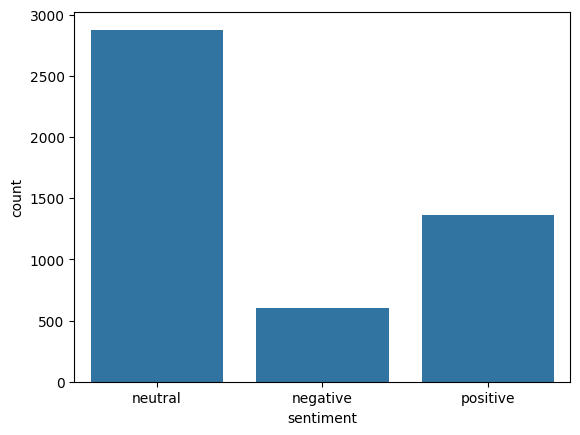

In [5]:
# Let's observe distribution of positive / negative sentiments in dataset

import seaborn as sns
sns.countplot(x='sentiment', data=df)

In [7]:
# import b2_preprocessing_function
from b2_preprocessing_function import CustomPreprocess

In [8]:
custom = CustomPreprocess()

In [9]:
# Calling preprocessing_text function on financial news
X = []
sentences = list(df['Message'])
for sen in sentences:
    X.append(custom.preprocess_text(sen))

In [10]:
df.head()

,sentiment,Message
567,positive,"The new agreement , which expands a long-estab..."
1752,positive,( ADP News ) - Finnish handling systems provid...
995,positive,The world 's biggest magazine paper maker said...
601,positive,"a January 11 , 2010 EPHC board of directors ha..."
568,positive,With this appointment Kaupthing Bank aims to f...


In [11]:
#Convert string to numeric
sentiment  = {'positive': 0,'neutral': 1,'negative':2}
df['sentiment'] = [sentiment[item] if item in sentiment else None for item in df['sentiment']]
df.head()

,sentiment,Message
567,0,"The new agreement , which expands a long-estab..."
1752,0,( ADP News ) - Finnish handling systems provid...
995,0,The world 's biggest magazine paper maker said...
601,0,"a January 11 , 2010 EPHC board of directors ha..."
568,0,With this appointment Kaupthing Bank aims to f...


In [12]:
# The train set will be used to train our deep learning models
# while test set will be used to evaluate how well our model performs
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

<h1>Preparing embedding layer

In [13]:
# Embedding layer expects the words to be in numeric form
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [14]:
import io
import json

In [18]:
# Saving
tokenizer_json = word_tokenizer.to_json()
with io.open('b3_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [15]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

4374

In [16]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [20]:

# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.
from numpy import zeros
embeddings_dictionary = dict()
embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

embedding_matrix.shape

(4374, 100)

<h1>Model Training

<h2>Simple Neural Network

In [21]:
# Neural Network architecture

snn_model = Sequential()
snn_model.add(Embedding(
    input_dim=vocab_length,         # 7994
    output_dim=100,                 # số chiều embedding
    weights=[embedding_matrix],     # (7994, 100)
    input_shape=(100,),               # phải đúng bằng số chiều của mỗi sample
    trainable=False
))
snn_model.add(Flatten())
snn_model.add(Dense(3, activation='softmax'))

snn_model.summary()

c:\Users\nguye\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │       437,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │        30,003 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 467,403 (1.78 MB)

 Trainable params: 30,003 (117.20 KB)

 Non-trainable params: 437,400 (1.67 MB)

In [22]:
# Model compiling
snn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
print(snn_model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │       437,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │        30,003 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 467,403 (1.78 MB)

 Trainable params: 30,003 (117.20 KB)

 Non-trainable params: 437,400 (1.67 MB)

None


In [23]:
# Model training
snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - acc: 0.3310 - loss: 1.0986 - val_acc: 0.3414 - val_loss: 1.0987
Epoch 2/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.3498 - loss: 1.0984 - val_acc: 0.3414 - val_loss: 1.0989
Epoch 3/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.3487 - loss: 1.0984 - val_acc: 0.3000 - val_loss: 1.0991
Epoch 4/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.3214 - loss: 1.0988 - val_acc: 0.3000 - val_loss: 1.0993
Epoch 5/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.3408 - loss: 1.0985 - val_acc: 0.3000 - val_loss: 1.0994
Epoch 6/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.3325 - loss: 1.0984 - val_acc: 0.3000 - val_loss: 1.0995


In [24]:
# Predictions on the Test Set
score = snn_model.evaluate(X_test, y_test, verbose=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.3849 - loss: 1.0993 


In [25]:
# Model Performance
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 1.0991463661193848
Test Accuracy: 0.352617084980011


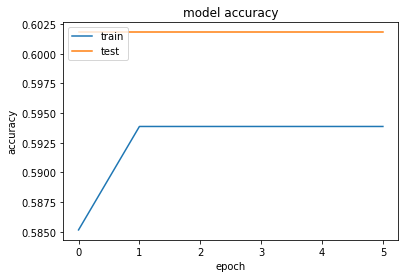

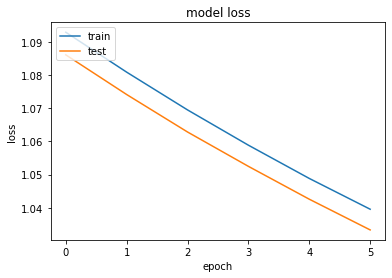

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

<h2>Convolutional Neural Network

In [ ]:
# Neural Network architecture

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_shape=(maxlen,) , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(3  , activation='softmax'))

cnn_model.summary()
# Model compiling

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

# Model training
cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.2)
# Predictions on the Test Set
score = cnn_model.evaluate(X_test, y_test, verbose=1)



Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 100, 100)       │       799,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 96, 128)        │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 863,915 (3.30 MB)

 Trainable params: 64,515 (252.01 KB)

 Non-trainable params: 799,400 (3.05 MB)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - acc: 0.5404 - loss: 1.0955 - val_acc: 0.6018 - val_loss: 1.0857
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.5853 - loss: 1.0834 - val_acc: 0.6018 - val_loss: 1.0736
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.5921 - loss: 1.0717 - val_acc: 0.6018 - val_loss: 1.0624
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.5828 - loss: 1.0624 - val_acc: 0.6018 - val_loss: 1.0523
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.5884 - loss: 1.0519 - val_acc: 0.6018 - val_loss: 1.0423
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.5825 - loss: 1.0436 - val_acc: 0.6018 - val_loss: 1.0332
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.5856 - loss: 1.0346 - val_acc: 0.6018 - val_loss: 1.0248
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.5886 - loss: 1.0264 - val_acc: 0.6018 - val_loss: 1.0169
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.5843

In [ ]:
# Model Performance
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.9605516791343689
Test Accuracy: 0.5886598229408264


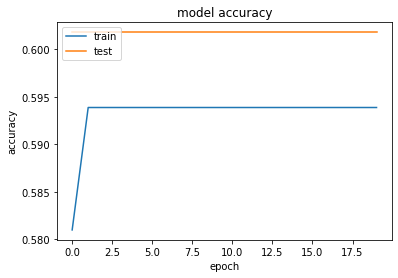

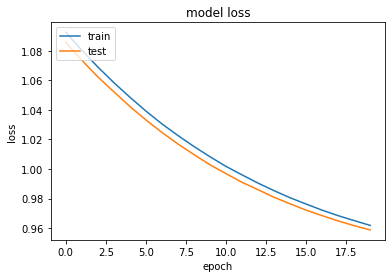

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

<h2>Recurrent Neural Network (LSTM)

In [ ]:
# Neural Network architecture

lstm_model = Sequential()
lstm_model.add(Embedding(vocab_length, 100, weights=[embedding_matrix], input_shape=(100,), trainable=False))
lstm_model.add(LSTM(64, activation='tanh'))  # hoặc không cần truyền activation, mặc định là 'tanh'
lstm_model.add(Dense(3, activation='softmax'))  # 3 là số lớp

lstm_model.summary()
# Model compiling

lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
# Model training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.2)
# Predictions on the Test Set
score = lstm_model.evaluate(X_test, y_test, verbose=1)



Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (None, 100, 100)       │       799,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 841,835 (3.21 MB)

 Trainable params: 42,435 (165.76 KB)

 Non-trainable params: 799,400 (3.05 MB)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - acc: 0.5490 - loss: 1.0613 - val_acc: 0.6018 - val_loss: 0.9587
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - acc: 0.6069 - loss: 0.9356 - val_acc: 0.6018 - val_loss: 0.9357
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - acc: 0.5999 - loss: 0.9184 - val_acc: 0.6018 - val_loss: 0.9311
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - acc: 0.5953 - loss: 0.9197 - val_acc: 0.6018 - val_loss: 0.9302
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - acc: 0.5946 - loss: 0.9283 - val_acc: 0.6018 - val_loss: 0.9314
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - acc: 0.6060 - loss: 0.9211 - val_acc: 0.6018 - val_loss: 0.9314
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - acc: 0.5859 - loss: 0.9372 - val_acc: 0.6018 - val_loss: 0.9307
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - acc: 0.5950 - loss: 0.9286 - val_acc: 0.6018 - val_loss: 0.9311
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - acc: 0.5939

In [ ]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.9214172959327698
Test Accuracy: 0.5886598229408264


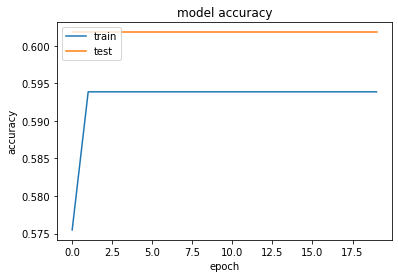

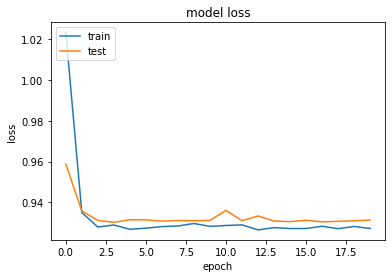

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()